In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import datetime
import seaborn as sns

import statsmodels.stats.diagnostic as dg
import statsmodels.tools.tools as ct
import statsmodels.regression.linear_model as rg
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
START_DATE = "2013-01-02"
END_DATE = "2021-12-31"
SPLIT_FACTOR = 0.85
SPLIT_VAL_FACTOR = 0.25

# Data Reading

In [69]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
def read_csv(path, sep = ";"):
    raw_data = pd.read_csv(path, header=0, sep = sep, parse_dates=[0], date_parser=parser)
    mask = (raw_data['Date'] >= START_DATE) & (raw_data['Date'] <= END_DATE)
    df = raw_data.loc[mask]
    df.reset_index(inplace = True, drop = True)
    return df

In [6]:
stock_df = read_csv(r'data\dataset_full.csv')
inf_data = read_csv(r'data\inflation_data.csv')
company_data = read_csv(r'data\AMD-full.csv', sep = ",")

In [7]:
inf_data["Date_inf"] = inf_data["Date"]
inf_data = inf_data.drop(labels=['Date'], axis=1)
company_data["Date_comp"] = company_data["Date"]
company_data = company_data.drop(labels=["Date"], axis=1)

In [8]:
stock_df = stock_df.merge(inf_data, left_index=True,right_index=True)
stock_df = stock_df.merge(company_data, left_index=True,right_index=True)
stock_df = stock_df.drop(labels=["Date_comp", "Date_inf"], axis=1)
stock_df.head()

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,Close,Volume,Adj Close,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,2013-01-02,1462.420044,13412.54980,3112.260010,8632.009766,14.68,2269.127930,1.319784,86.599998,1.624695,...,28.670000,6677100.0,22.333021,21.331151,21.544037,21.318135,67.941068,0.248235,28.276532,26.462801
1,2013-01-03,1459.369995,13391.36035,3100.570068,8607.790039,14.56,2269.127930,1.318218,87.275002,1.625250,...,28.440001,3970700.0,22.153856,21.405942,21.617482,21.379339,64.147206,0.281482,28.441684,26.473316
2,2013-01-04,1466.469971,13435.20996,3101.659912,8667.679688,13.83,2276.991943,1.303271,87.739998,1.608234,...,29.219999,5842400.0,22.761450,21.529170,21.782178,21.472445,70.220351,0.352791,28.711065,26.420268
3,2013-01-07,1461.890015,13384.29004,3098.810059,8636.910156,13.79,2285.364014,1.306745,88.197998,1.606787,...,28.010000,8339200.0,21.818892,21.555509,21.842268,21.520295,54.731819,0.329449,28.761600,26.540400
4,2013-01-08,1457.150024,13328.84961,3091.810059,8604.379883,13.62,2276.070068,1.312508,87.252998,1.612201,...,28.340000,3880400.0,22.075962,21.602823,21.936858,21.580387,57.486092,0.327914,28.805516,26.614484


# Data Analysing and Visualisation 

In [9]:
stock_df[stock_df.isna().any(axis=1)]

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,Close,Volume,Adj Close,ewm,ma_7,ma_21,rsi,macd,bolu,bold


In [10]:
stock_df.dtypes

Date     datetime64[ns]
^GSPC           float64
^DJI            float64
^IXIC           float64
^NYA            float64
              ...      
ma_21           float64
rsi             float64
macd            float64
bolu            float64
bold            float64
Length: 100, dtype: object

In [11]:
stock_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
^GSPC,2267.0,2592.580396,781.401906,1457.150024,2020.714966,2432.459961,2935.729981,4793.060059
^DJI,2267.0,22382.318566,5996.247598,13328.849610,17323.235355,21328.470700,26327.334960,36488.628910
^IXIC,2267.0,7115.422644,3284.071455,3091.810059,4727.080079,6234.410156,8118.175049,16057.440430
^NYA,2267.0,11933.662107,1996.464400,8604.379883,10515.500000,11514.400390,12884.955075,17310.509770
^VIX,2267.0,17.000362,7.122941,9.140000,12.840000,14.910000,18.884999,82.690002
...,...,...,...,...,...,...,...,...
ma_21,2267.0,39.311356,8.816601,21.318135,35.368502,38.140797,41.428484,66.493859
rsi,2267.0,53.290940,11.930419,17.612542,45.903844,53.423725,61.844047,84.127210
macd,2267.0,0.134935,0.623812,-2.827387,-0.141153,0.166226,0.509713,2.376329
bolu,2267.0,46.452590,7.763514,28.276532,42.368106,45.193994,49.467290,71.070118


In [12]:
corr = stock_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [13]:
num_training_days = int(stock_df.shape[0]*SPLIT_FACTOR)
split_point = stock_df[num_training_days: num_training_days+1].values[0][0]
year = split_point.year
month = split_point.month
day = split_point.day
print(f"Number of training days: {num_training_days}. Number of test days: {stock_df.shape[0]-num_training_days}.")
print(f"Split date is: {split_point}. Index is: {stock_df[num_training_days: num_training_days+1].index.values[0]}")

Number of training days: 1926. Number of test days: 341.
Split date is: 2020-08-26 00:00:00. Index is: 1926


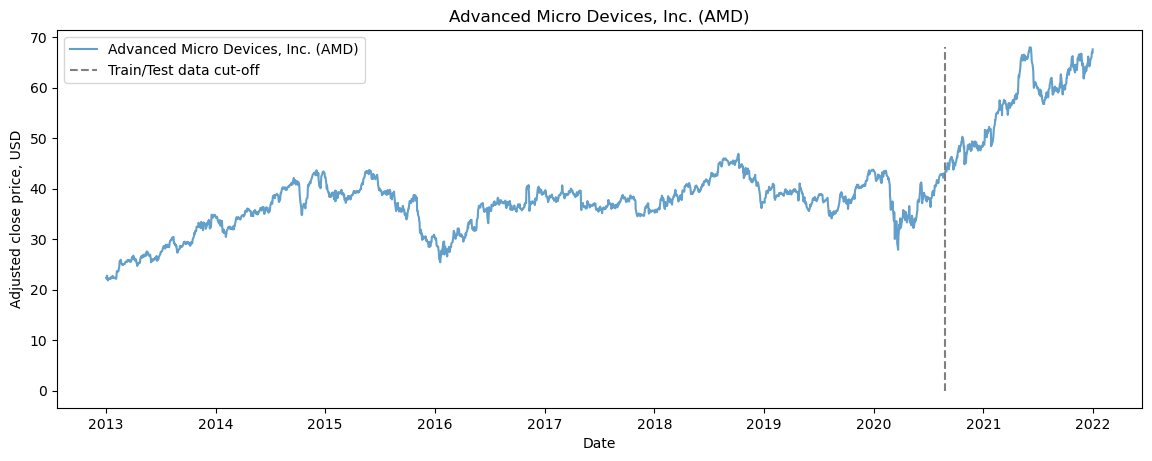

In [14]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(stock_df['Date'], stock_df['Adj Close'], label='Advanced Micro Devices, Inc. (AMD)', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, stock_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.show()

In [15]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(3, 1, 1)
    plt.plot(dataset['ma_7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['ma_21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['Adj Close'],label='Adj Close', color='b')
    plt.plot(dataset['bolu'],label='Bollinger Upper Band', color='c')
    plt.plot(dataset['bold'],label='Bollinger Lower Band', color='c')
    plt.fill_between(x_, dataset['bolu'], dataset['bold'], alpha=0.35)
    plt.title('Technical indicators for Advanced Micro Devices, Inc. (AMD) - last {} days.'.format(last_days))
    plt.ylabel('Adjusted close price, USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(3, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['macd'],label='MACD', linestyle='-.')
    plt.hlines(5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.legend()
    
    # Plot third subplot
    plt.subplot(3, 1, 3)
    plt.title('RSI')
    plt.plot(dataset['rsi'],label='RSI', color='b',linestyle='-')
    plt.legend()
    
    plt.show()

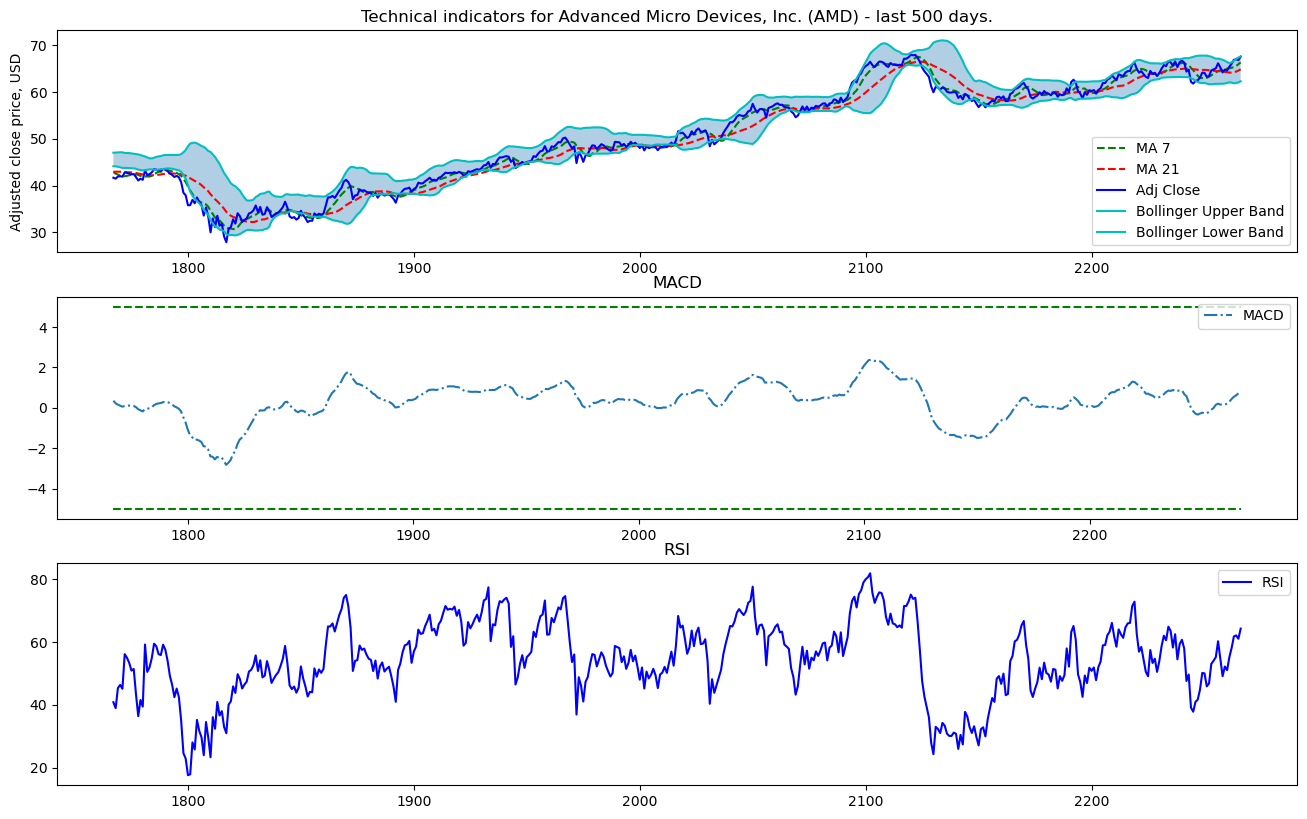

In [16]:
plot_technical_indicators(stock_df, 500)

# Feature Selection
## 1. Heteroskedastic analysis and serial correlation

In [17]:
def statistic(df, param):
    df = ct.add_constant(df)
    ivar = ["const"] + param
    reg = rg.OLS(df["Adj Close"], df[ivar], hasconst=bool).fit()
    res = reg.resid
    dw = durbin_watson(res)
    bplmt_statistic = np.round(dg.het_breuschpagan(res, exog_het = df[ivar])[0], 6)
    bplmt_p_value = np.round(dg.het_breuschpagan(res, exog_het = df[ivar])[1], 6)

    return bplmt_statistic, bplmt_p_value, dw, df[ivar]

In [18]:
parameters = []
for el in stock_df.columns.tolist():
    if el != "Adj Close" and el != 'Date':
        parameters.append([el])

In [19]:
param =  (parameters)
pairplot_list = []

for el in param:   
    col_names = ["Adj Close"] + el
    data_for_test = stock_df[col_names]
    bp_statistic = statistic(data_for_test, el)[0]
    bp_pvalue = statistic(data_for_test, el)[1]
    dw = statistic(data_for_test, el)[2]
#     if dw > 1 and dw < 3:
    if bp_pvalue>=0.05:# and (dw >= 1 and dw <= 3)
        pairplot_list.append(el[0])
        print("--------------------")
        print(f"Heteroskedastic analysis for {el}")
        print()
        print(f"Breusch-Pagan LM test statistic", statistic(data_for_test, el)[0])
        print("Breusch-Pagan LM test P-Value: ", statistic(data_for_test, el)[1])
        print("durbin_watson: ", statistic(data_for_test, el)[2]) 
        print()

--------------------
Heteroskedastic analysis for ['EURUSD=X']

Breusch-Pagan LM test statistic 1.640221
Breusch-Pagan LM test P-Value:  0.200295
durbin_watson:  0.004696194517420424

--------------------
Heteroskedastic analysis for ['GBPUSD=X']

Breusch-Pagan LM test statistic 2.719749
Breusch-Pagan LM test P-Value:  0.099114
durbin_watson:  0.005100674333547253

--------------------
Heteroskedastic analysis for ['JLCYX']

Breusch-Pagan LM test statistic 1.972508
Breusch-Pagan LM test P-Value:  0.160182
durbin_watson:  0.015934197922661864

--------------------
Heteroskedastic analysis for ['CNPIX']

Breusch-Pagan LM test statistic 2.798797
Breusch-Pagan LM test P-Value:  0.094335
durbin_watson:  0.016905707828708313

--------------------
Heteroskedastic analysis for ['OAKMX']

Breusch-Pagan LM test statistic 3.259802
Breusch-Pagan LM test P-Value:  0.070998
durbin_watson:  0.015773387052156078

--------------------
Heteroskedastic analysis for ['BPTRX']

Breusch-Pagan LM test statis

In [20]:
print(pairplot_list, len(pairplot_list))

['EURUSD=X', 'GBPUSD=X', 'JLCYX', 'CNPIX', 'OAKMX', 'BPTRX', 'UOPIX', 'RYVLX', 'ACN', 'WFC', 'T', 'LOW'] 12


In [41]:
stat_most_important = pairplot_list

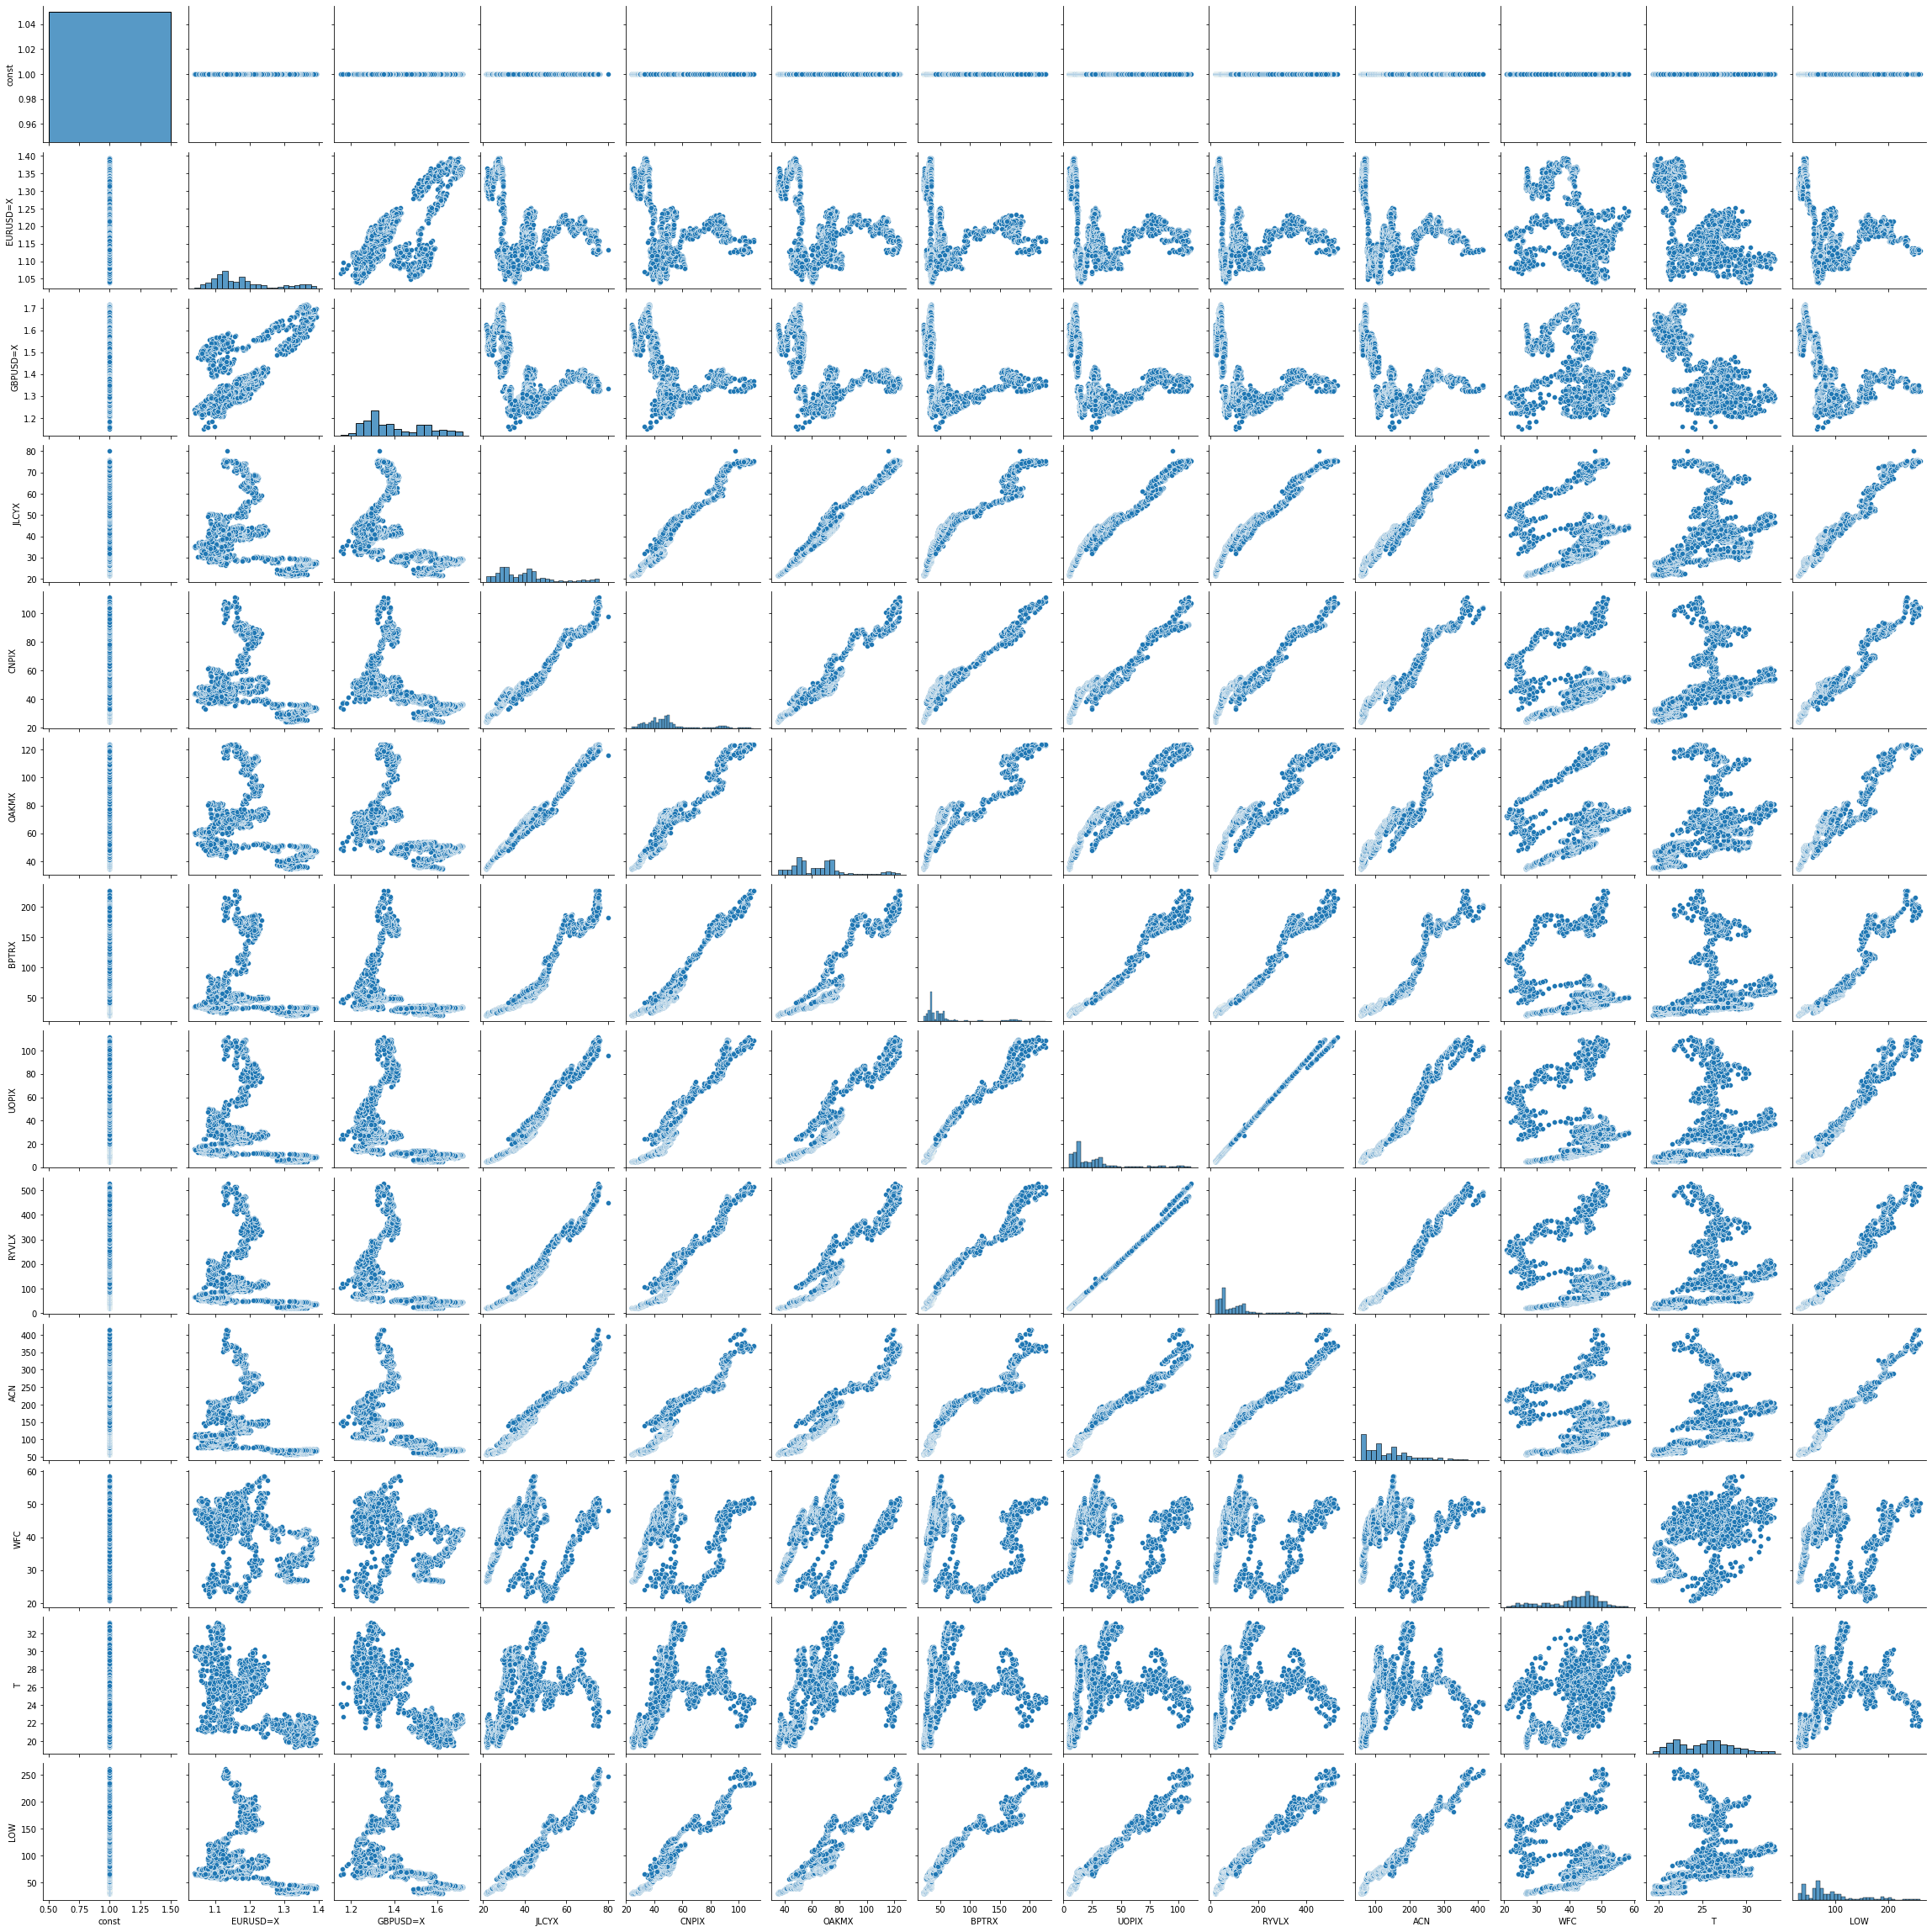

In [68]:
col_names = ["Adj Close"] + pairplot_list
data_for_test = stock_df[col_names]
sns.pairplot(statistic(data_for_test, pairplot_list)[3])

## 2. XGBoosting

In [22]:
print('Total dataset has {} samples, and {} features.'.format(stock_df.shape[0], \
                                                              stock_df.shape[1]))

Total dataset has 2267 samples, and 100 features.


In [23]:
def get_feature_importance_data(df):
    data = df.copy()
    y = data['Adj Close']
    data = data.drop('Adj Close', axis=1)
    X = data.iloc[:, 1:]
#     X = (X - X.min ()) / (X.max () - X.min ())
   
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [24]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(stock_df)
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

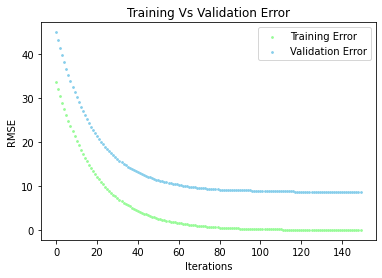

In [25]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error', color = "palegreen", s=3)
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error', color = "skyblue", s=3)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()
# Данните за 4 годишния сет са много малко и модела няма достатъчно капацитет. 0,60  0,75  0,8 0,82 0,83  0,85  0.9  0.95--->train_samples

Text(0.5, 1.0, 'Top 30 features important')

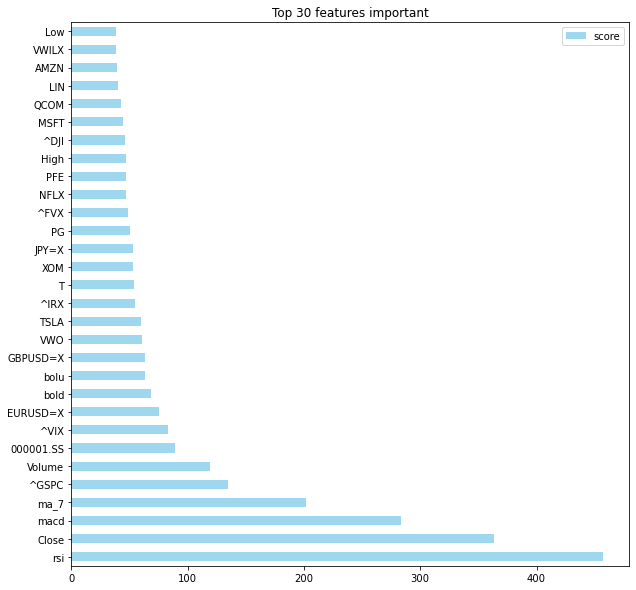

In [26]:
# https://matplotlib.org/stable/gallery/color/named_colors.html
feature_important = xgbModel.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(30, columns="score").plot(kind='barh', figsize = (10,10), color = 'skyblue', alpha = 0.8)
plt.title("Top 30 features important")
## plot top 30 features 

In [27]:
data.nlargest(30, columns="score")

,score
rsi,457.0
Close,363.0
macd,283.0
ma_7,202.0
^GSPC,135.0
Volume,119.0
000001.SS,89.0
^VIX,83.0
EURUSD=X,75.0
bold,68.0


In [38]:
xgb_most_important_30 = (data.nlargest(30, columns="score")).index.tolist()
xgb_most_important_30

['rsi',
 'Close',
 'macd',
 'ma_7',
 '^GSPC',
 'Volume',
 '000001.SS',
 '^VIX',
 'EURUSD=X',
 'bold',
 'bolu',
 'GBPUSD=X',
 'VWO',
 'TSLA',
 '^IRX',
 'T',
 'XOM',
 'JPY=X',
 'PG',
 '^FVX',
 'NFLX',
 'PFE',
 'High',
 '^DJI',
 'MSFT',
 'QCOM',
 'LIN',
 'AMZN',
 'VWILX',
 'Low']

## 3. PCA

In [28]:
pca_df = stock_df.drop('Adj Close', axis=1)
pca_df = stock_df.drop('Date', axis=1)
pca_df

,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,^IRX,...,Close,Volume,Adj Close,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,1462.420044,13412.54980,3112.260010,8632.009766,14.680000,2269.127930,1.319784,86.599998,1.624695,0.055,...,28.670000,6677100.0,22.333021,21.331151,21.544037,21.318135,67.941068,0.248235,28.276532,26.462801
1,1459.369995,13391.36035,3100.570068,8607.790039,14.560000,2269.127930,1.318218,87.275002,1.625250,0.065,...,28.440001,3970700.0,22.153856,21.405942,21.617482,21.379339,64.147206,0.281482,28.441684,26.473316
2,1466.469971,13435.20996,3101.659912,8667.679688,13.830000,2276.991943,1.303271,87.739998,1.608234,0.065,...,29.219999,5842400.0,22.761450,21.529170,21.782178,21.472445,70.220351,0.352791,28.711065,26.420268
3,1461.890015,13384.29004,3098.810059,8636.910156,13.790000,2285.364014,1.306745,88.197998,1.606787,0.058,...,28.010000,8339200.0,21.818892,21.555509,21.842268,21.520295,54.731819,0.329449,28.761600,26.540400
4,1457.150024,13328.84961,3091.810059,8604.379883,13.620000,2276.070068,1.312508,87.252998,1.612201,0.060,...,28.340000,3880400.0,22.075962,21.602823,21.936858,21.580387,57.486092,0.327914,28.805516,26.614484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,4791.189941,36302.37891,15871.259770,17141.089840,17.680000,3615.969971,1.132426,114.333000,1.340430,0.043,...,66.070000,1175900.0,66.070000,64.719121,65.231429,64.166191,58.105626,0.302337,66.388560,62.033441
2263,4786.350098,36398.21094,15781.719730,17134.160160,17.540001,3630.112061,1.133003,114.792000,1.344267,0.050,...,66.930000,1049900.0,66.930000,64.920110,65.340001,64.286667,61.772180,0.438992,66.711888,61.891113
2264,4793.060059,36488.62891,15766.219730,17149.929690,16.950001,3597.000000,1.131478,114.773003,1.343328,0.045,...,67.010002,1038500.0,67.010002,65.110100,65.588573,64.391429,62.104439,0.547438,67.116617,61.917051
2265,4778.729980,36398.07813,15741.559570,17164.240230,17.330000,3619.189941,1.136015,114.947998,1.349879,0.025,...,66.860001,906900.0,66.860001,65.269182,65.965716,64.612857,61.033303,0.614197,67.396706,62.084962


In [29]:
pca = PCA(n_components=.95)
x_pca = StandardScaler().fit_transform(pca_df)
principalComponents = pca.fit_transform(x_pca)
pca.explained_variance_ratio_

array([0.7523255 , 0.07015575, 0.05575558, 0.03649675, 0.02155814,
       0.01086641, 0.00888205])

In [30]:
n_pcs= pca.components_.shape[0]
initial_feature_names = pca_df.columns
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['^GSPC', 'XOM', '^IRX', 'JPY=X', 'macd', '^VIX', 'Volume']

In [39]:
pca_most_important = most_important_names

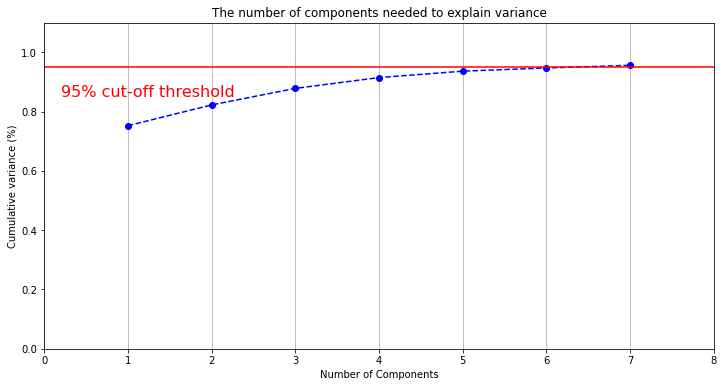

In [31]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(most_important_names)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)


plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(most_important_names)+2, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y = 0.95, color='r', linestyle='-')
plt.text(0.2, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

#  Prepare Dataset for Time Series

In [51]:
most_important_features = list(set(stat_most_important + xgb_most_important_30 + pca_most_important))

In [52]:
len(most_important_features), list(most_important_features)

(39,
 ['XOM',
  'JPY=X',
  '^FVX',
  'PG',
  'VWILX',
  'Low',
  'Close',
  'EURUSD=X',
  'macd',
  'LIN',
  '000001.SS',
  'bolu',
  '^IRX',
  '^DJI',
  'ma_7',
  'PFE',
  'OAKMX',
  'CNPIX',
  'QCOM',
  '^GSPC',
  'bold',
  '^VIX',
  'VWO',
  'UOPIX',
  'TSLA',
  'JLCYX',
  'AMZN',
  'rsi',
  'GBPUSD=X',
  'WFC',
  'RYVLX',
  'MSFT',
  'BPTRX',
  'NFLX',
  'LOW',
  'High',
  'ACN',
  'T',
  'Volume'])

# Send Preprocessed Data to Files

In [53]:
dataset_most_important_feature = stock_df[["Date","Adj Close" ] + most_important_features]
# dataset_most_important_feature.to_csv(r'data\data_for_time_series\dataset_most_important_feature.csv', index = False, header=True)
dataset_most_important_feature

,Date,Adj Close,XOM,JPY=X,^FVX,PG,VWILX,Low,Close,EURUSD=X,...,WFC,RYVLX,MSFT,BPTRX,NFLX,LOW,High,ACN,T,Volume
0,2013-01-02,22.333021,60.387547,86.599998,0.763,52.756119,52.825130,28.049999,28.670000,1.319784,...,26.926046,22.180546,23.074232,22.064262,13.144286,30.915403,28.680000,57.524582,20.130396,6677100.0
1,2013-01-03,22.153856,60.278633,87.275002,0.808,52.421600,52.419884,28.299999,28.440001,1.318218,...,26.703266,21.948225,22.765125,22.159204,13.798571,30.624966,28.760000,57.316322,20.141891,3970700.0
2,2013-01-04,22.761450,60.557713,87.739998,0.819,52.528057,52.630951,28.459999,29.219999,1.303271,...,26.841543,21.817141,22.339064,22.358580,13.711429,30.394314,29.290001,57.632862,20.262678,5842400.0
3,2013-01-07,21.818892,59.856579,88.197998,0.813,52.170712,52.419884,27.930000,28.010000,1.306745,...,26.710939,21.814545,22.297297,22.235155,14.171429,29.693823,29.100000,57.382957,20.354708,8339200.0
4,2013-01-08,22.075962,60.230972,87.252998,0.785,52.087082,52.242596,27.900000,28.340000,1.312508,...,26.664845,21.726290,22.180330,22.149710,13.880000,29.710911,28.360001,57.716152,20.010992,3880400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,61.889999,114.333000,1.252,161.100357,139.149994,65.250000,66.070000,1.132426,...,48.770000,494.809998,342.450012,202.779999,613.119995,252.866135,66.089996,414.255981,24.286488,1175900.0
2263,2021-12-28,66.930000,61.689999,114.792000,1.245,161.965683,138.559998,66.000000,66.930000,1.133003,...,48.419998,490.130005,341.250000,202.089996,610.710022,253.185089,66.980003,414.196137,24.325691,1049900.0
2264,2021-12-29,67.010002,61.150002,114.773003,1.294,163.308441,138.330002,66.870003,67.010002,1.131478,...,48.450001,490.200012,341.950012,202.089996,610.539978,256.723419,67.459999,414.345795,24.149275,1038500.0
2265,2021-12-30,66.860001,60.790001,114.947998,1.274,161.896072,139.619995,66.830002,66.860001,1.136015,...,48.099998,486.529999,339.320007,200.660004,612.090027,255.547317,67.410004,412.759857,24.286488,906900.0


In [67]:
df = stock_df[["Date", "Adj Close"]]
df1 = stock_df.drop(["Date", "Adj Close"], axis=1)
rearanged_dataset = df.merge(df1, left_index=True,right_index=True)

dataset_full_features = rearanged_dataset
# dataset_full_features.to_csv(r'data\data_for_time_series\dataset_full_features.csv', index = False, header=True)
dataset_full_features

,Date,Adj Close,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,2013-01-02,22.333021,1462.420044,13412.54980,3112.260010,8632.009766,14.680000,2269.127930,1.319784,86.599998,...,28.139999,28.670000,6677100.0,21.331151,21.544037,21.318135,67.941068,0.248235,28.276532,26.462801
1,2013-01-03,22.153856,1459.369995,13391.36035,3100.570068,8607.790039,14.560000,2269.127930,1.318218,87.275002,...,28.760000,28.440001,3970700.0,21.405942,21.617482,21.379339,64.147206,0.281482,28.441684,26.473316
2,2013-01-04,22.761450,1466.469971,13435.20996,3101.659912,8667.679688,13.830000,2276.991943,1.303271,87.739998,...,28.500000,29.219999,5842400.0,21.529170,21.782178,21.472445,70.220351,0.352791,28.711065,26.420268
3,2013-01-07,21.818892,1461.890015,13384.29004,3098.810059,8636.910156,13.790000,2285.364014,1.306745,88.197998,...,29.100000,28.010000,8339200.0,21.555509,21.842268,21.520295,54.731819,0.329449,28.761600,26.540400
4,2013-01-08,22.075962,1457.150024,13328.84961,3091.810059,8604.379883,13.620000,2276.070068,1.312508,87.252998,...,27.930000,28.340000,3880400.0,21.602823,21.936858,21.580387,57.486092,0.327914,28.805516,26.614484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,4791.189941,36302.37891,15871.259770,17141.089840,17.680000,3615.969971,1.132426,114.333000,...,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,58.105626,0.302337,66.388560,62.033441
2263,2021-12-28,66.930000,4786.350098,36398.21094,15781.719730,17134.160160,17.540001,3630.112061,1.133003,114.792000,...,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,61.772180,0.438992,66.711888,61.891113
2264,2021-12-29,67.010002,4793.060059,36488.62891,15766.219730,17149.929690,16.950001,3597.000000,1.131478,114.773003,...,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,62.104439,0.547438,67.116617,61.917051
2265,2021-12-30,66.860001,4778.729980,36398.07813,15741.559570,17164.240230,17.330000,3619.189941,1.136015,114.947998,...,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,61.033303,0.614197,67.396706,62.084962
